<a href="https://colab.research.google.com/github/anudaindu/CM2604_Telco_Churn_Anuda/blob/main/DiabetesRiskPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ============================================
# 1. SETUP AND DATA LOADING
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve, auc, log_loss
)
import warnings
warnings.filterwarnings('ignore')

# Import all required models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
file_path = '/content/drive/MyDrive/YourFolder/balanced_diabetes_data.csv'
df = pd.read_csv(file_path)

In [5]:


print("="*60)
print("1. DATA LOADING COMPLETE")
print("="*60)
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

1. DATA LOADING COMPLETE
Dataset shape: (1761, 14)

First 5 rows:
   user_id        date     weight      height  blood_glucose  \
0      595  2022-10-13  85.563099  150.000000     173.937235   
1      275  2021-10-28  55.277370  182.130977      96.510162   
2      854  2023-07-24  87.835248  179.191542     148.821657   
3      157  2021-06-20  97.986618  163.118496     124.992145   
4      663  2022-12-26  69.508701  150.000000     163.889129   

   physical_activity  diet  medication_adherence  stress_level  sleep_hours  \
0          55.184665     1                     1             2     9.268495   
1          11.674518     0                     0             2    10.361847   
2           7.856864     1                     0             2     5.025379   
3           5.251467     0                     1             0     6.398124   
4          37.466971     1                     0             1     6.932074   

   hydration_level   bmi  risk_score risk_level  
0                1  38.0

In [6]:

# ============================================
# 2. DATA CLEANING
# ============================================
print("\n" + "="*60)
print("2. DATA CLEANING")
print("="*60)

# Remove duplicates
df = df.drop_duplicates()

# Clean unrealistic values
df = df[(df['weight'] > 30) & (df['weight'] < 200)]
df = df[(df['height'] > 100) & (df['height'] < 250)]
df = df[(df['bmi'] > 10) & (df['bmi'] < 60)]
df = df[(df['blood_glucose'] >= 70) & (df['blood_glucose'] <= 300)]
df = df[(df['sleep_hours'] >= 0) & (df['sleep_hours'] <= 24)]

print(f"Shape after cleaning: {df.shape}")

# Check correlation between features
print("\n" + "-"*40)
print("CORRELATION ANALYSIS")
print("-"*40)
# Check correlation between weight, height, and BMI
correlation_check = df[['weight', 'height', 'bmi']].corr()
print("Correlation between weight, height, and BMI:")
print(correlation_check)


2. DATA CLEANING
Shape after cleaning: (713, 14)

----------------------------------------
CORRELATION ANALYSIS
----------------------------------------
Correlation between weight, height, and BMI:
          weight    height       bmi
weight  1.000000 -0.048747  0.875669
height -0.048747  1.000000 -0.512119
bmi     0.875669 -0.512119  1.000000



3. EXPLORATORY DATA ANALYSIS


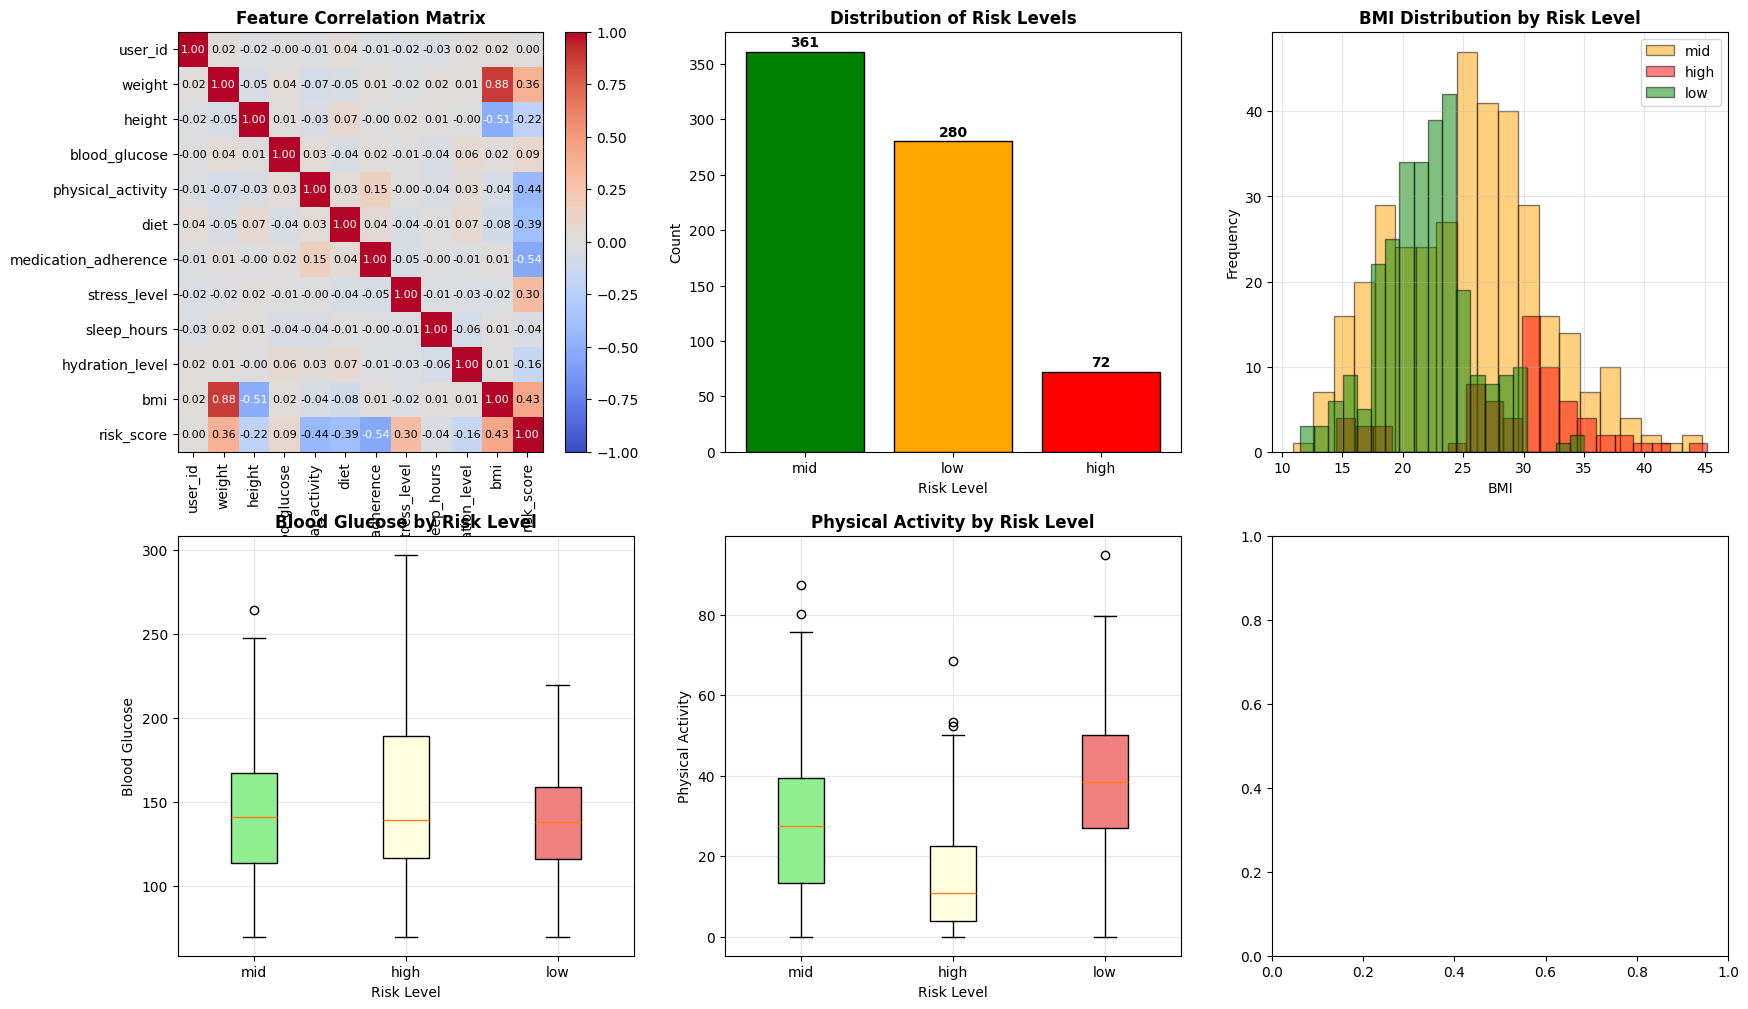

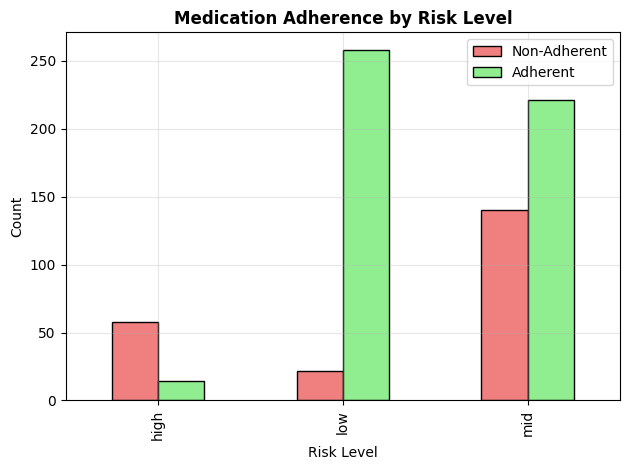


----------------------------------------
CORRELATION INSIGHTS
----------------------------------------
1. BMI has high correlation with weight and height
2. Keeping BMI only - removing weight and height to avoid multicollinearity
3. This reduces feature redundancy and improves model stability


In [7]:
# ============================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================
print("\n" + "="*60)
print("3. EXPLORATORY DATA ANALYSIS")
print("="*60)

# Create figure for EDA plots
plt.figure(figsize=(20, 12))

# 1. Correlation heatmap for all numerical features
plt.subplot(2, 3, 1)
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im)
plt.title('Feature Correlation Matrix', fontsize=12, fontweight='bold')
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)

# Add correlation values
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        text = plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="white" if abs(correlation_matrix.iloc[i, j]) > 0.5 else "black",
                       fontsize=8)

# 2. Target variable distribution
plt.subplot(2, 3, 2)
risk_counts = df['risk_level'].value_counts()
risk_labels = risk_counts.index
risk_values = risk_counts.values
colors = ['green', 'orange', 'red']
bars = plt.bar(risk_labels, risk_values, color=colors, edgecolor='black')
plt.title('Distribution of Risk Levels', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Count')
for i, v in enumerate(risk_values):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')

# 3. BMI distribution by risk level
plt.subplot(2, 3, 3)
risk_levels = df['risk_level'].unique()
for risk in risk_levels:
    subset = df[df['risk_level'] == risk]
    if risk == 'low':
        color = 'green'
    elif risk == 'mid':
        color = 'orange'
    else:
        color = 'red'
    plt.hist(subset['bmi'], alpha=0.5, label=risk, color=color, bins=20, edgecolor='black')
plt.title('BMI Distribution by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Blood glucose by risk level
plt.subplot(2, 3, 4)
box_data = [df[df['risk_level'] == risk]['blood_glucose'].values for risk in risk_levels]
bp = plt.boxplot(box_data, labels=risk_levels, patch_artist=True)
colors_box = ['lightgreen', 'lightyellow', 'lightcoral']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
plt.title('Blood Glucose by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Blood Glucose')
plt.grid(True, alpha=0.3)

# 5. Physical activity by risk level
plt.subplot(2, 3, 5)
box_data = [df[df['risk_level'] == risk]['physical_activity'].values for risk in risk_levels]
bp = plt.boxplot(box_data, labels=risk_levels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
plt.title('Physical Activity by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Physical Activity')
plt.grid(True, alpha=0.3)

# 6. Medication adherence by risk level
plt.subplot(2, 3, 6)
medication_by_risk = df.groupby('risk_level')['medication_adherence'].value_counts().unstack()
medication_by_risk.plot(kind='bar', color=['lightcoral', 'lightgreen'], edgecolor='black')
plt.title('Medication Adherence by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.legend(['Non-Adherent', 'Adherent'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display correlation insights
print("\n" + "-"*40)
print("CORRELATION INSIGHTS")
print("-"*40)
print("1. BMI has high correlation with weight and height")
print("2. Keeping BMI only - removing weight and height to avoid multicollinearity")
print("3. This reduces feature redundancy and improves model stability")

In [8]:

# ============================================
# 4. DATA PREPROCESSING FOR MODELING
# ============================================
print("\n" + "="*60)
print("4. DATA PREPROCESSING")
print("="*60)

# Convert risk_level to binary (low=0, mid/high=1)
df['risk_binary'] = df['risk_level'].apply(lambda x: 0 if x == 'low' else 1)

print("Binary target distribution:")
print(df['risk_binary'].value_counts())
print(f"Proportions: {df['risk_binary'].value_counts(normalize=True).to_dict()}")

# Feature selection - REMOVE weight and height, KEEP BMI
features = [
    'blood_glucose', 'physical_activity', 'diet',
    'medication_adherence', 'stress_level', 'sleep_hours',
    'hydration_level', 'bmi'  # Keeping BMI only
]

print(f"\nSelected features (removed weight & height to avoid multicollinearity):")
for i, feature in enumerate(features, 1):
    print(f"{i}. {feature}")

X = df[features]
y = df['risk_binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create feature names for scaled data
feature_names = features

print("\nFeature scaling completed (StandardScaler)")


4. DATA PREPROCESSING
Binary target distribution:
risk_binary
1    433
0    280
Name: count, dtype: int64
Proportions: {1: 0.6072931276297335, 0: 0.39270687237026647}

Selected features (removed weight & height to avoid multicollinearity):
1. blood_glucose
2. physical_activity
3. diet
4. medication_adherence
5. stress_level
6. sleep_hours
7. hydration_level
8. bmi

Train set shape: (570, 8)
Test set shape: (143, 8)

Feature scaling completed (StandardScaler)


In [14]:
# ============================================
# 5. ML MODEL IMPLEMENTATION (with Ensembles)
# ============================================
print("\n" + "="*60)
print("5. MODEL TRAINING - WITH ENSEMBLES")
print("="*60)

# Import XGBoost
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Initialize models
models = {
    # Base Models
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),

    # Neural Network (ANN)
    'ANN': MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    ),

    # Bagging Methods
    'Random Forest': RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=10,
        min_samples_split=5
    ),

    'Bagging (DT)': BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=5),
        n_estimators=50,
        random_state=42
    ),

    # Boosting Methods
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=42,
        n_estimators=100
    ),

    'AdaBoost': AdaBoostClassifier(
        n_estimators=50,
        random_state=42
    ),

    # Advanced Boosting
    'XGBoost': XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
}

print("✓ Added ensemble methods and ANN:")
print("  - Base Models: Logistic Regression, Decision Tree, SVM, KNN, Naive Bayes")
print("  - Neural Network: ANN (MLP)")
print("  - Bagging: Random Forest, Bagging Classifier")
print("  - Boosting: Gradient Boosting, AdaBoost, XGBoost")

# Train models
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        # Special handling for ANN if needed
        if name == 'ANN':
            print("  Neural Network architecture: 2 hidden layers (64, 32)")
            print("  Using early stopping to prevent overfitting...")

        # Special handling for XGBoost to include eval_set for loss curves
        if name == 'XGBoost':
            model.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], verbose=False)
        else:
            model.fit(X_train_scaled, y_train)

        trained_models[name] = model

        # Show training completion for ANN
        if name == 'ANN':
            print(f"  ✓ {name} trained successfully (Loss: {model.loss_:.4f}, Iterations: {model.n_iter_})")
        else:
            print(f"  ✓ {name} trained successfully")

    except Exception as e:
        print(f"  ✗ Error training {name}: {str(e)}")

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE")
print("="*60)
print(f"✓ Total models trained: {len(trained_models)}")
print(f"✓ Models include: {', '.join(trained_models.keys())}")


5. MODEL TRAINING - WITH ENSEMBLES
✓ Added ensemble methods and ANN:
  - Base Models: Logistic Regression, Decision Tree, SVM, KNN, Naive Bayes
  - Neural Network: ANN (MLP)
  - Bagging: Random Forest, Bagging Classifier
  - Boosting: Gradient Boosting, AdaBoost, XGBoost

Training Logistic Regression...
  ✓ Logistic Regression trained successfully

Training Decision Tree...
  ✓ Decision Tree trained successfully

Training SVM...
  ✓ SVM trained successfully

Training KNN...
  ✓ KNN trained successfully

Training Naive Bayes...
  ✓ Naive Bayes trained successfully

Training ANN...
  Neural Network architecture: 2 hidden layers (64, 32)
  Using early stopping to prevent overfitting...
  ✓ ANN trained successfully (Loss: 0.3693, Iterations: 18)

Training Random Forest...
  ✓ Random Forest trained successfully

Training Bagging (DT)...
  ✓ Bagging (DT) trained successfully

Training Gradient Boosting...
  ✓ Gradient Boosting trained successfully

Training AdaBoost...
  ✓ AdaBoost trained 


6. MODEL EVALUATION

Evaluating Logistic Regression...


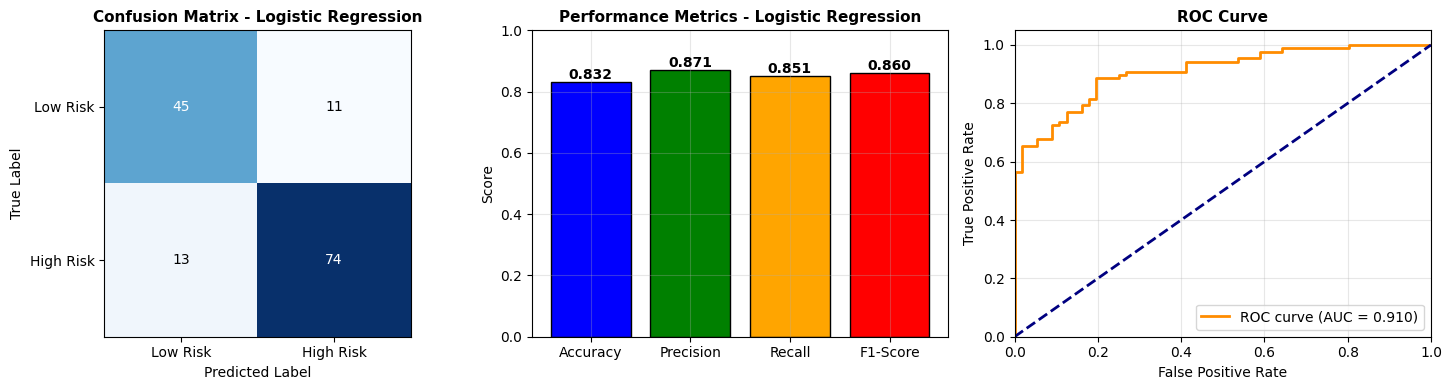

✓ Logistic Regression            | Accuracy: 0.8322 | F1-Score: 0.8605 | Type: Base
  ROC-AUC: 0.9097

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.78      0.80      0.79        56
   High Risk       0.87      0.85      0.86        87

    accuracy                           0.83       143
   macro avg       0.82      0.83      0.82       143
weighted avg       0.83      0.83      0.83       143

------------------------------------------------------------

Evaluating Decision Tree...


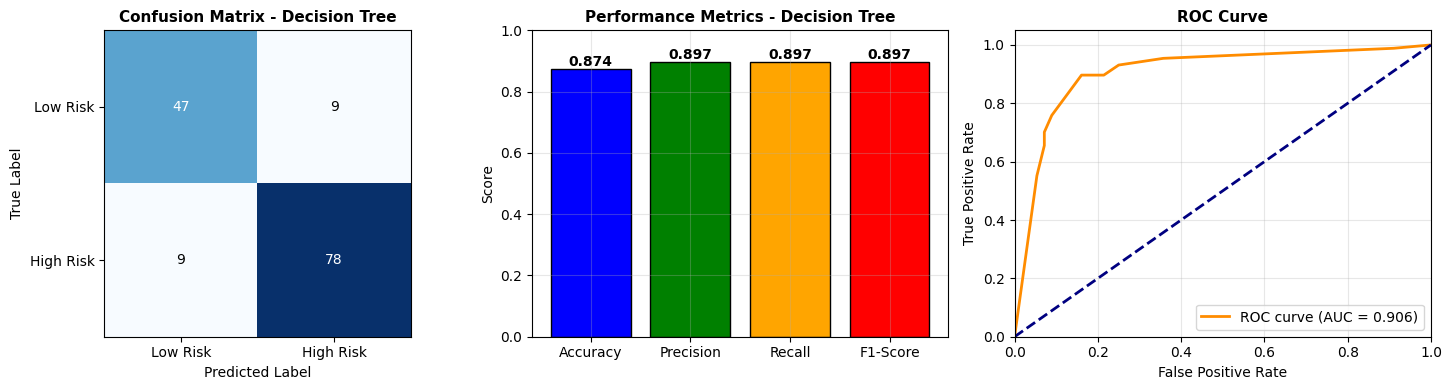

✓ Decision Tree                  | Accuracy: 0.8741 | F1-Score: 0.8966 | Type: Base
  ROC-AUC: 0.9058

Decision Tree Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.84      0.84      0.84        56
   High Risk       0.90      0.90      0.90        87

    accuracy                           0.87       143
   macro avg       0.87      0.87      0.87       143
weighted avg       0.87      0.87      0.87       143

------------------------------------------------------------

Evaluating SVM...


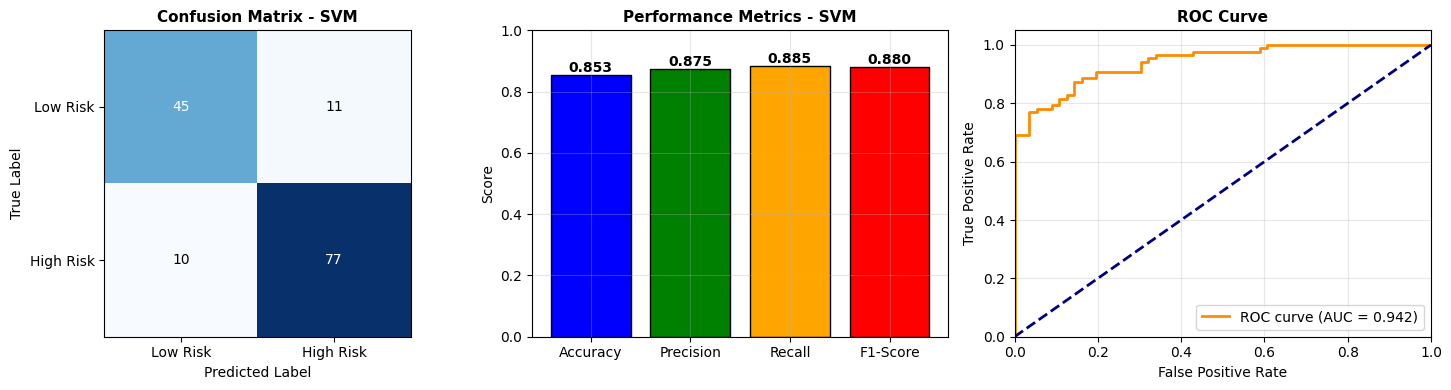

✓ SVM                            | Accuracy: 0.8531 | F1-Score: 0.8800 | Type: Base
  ROC-AUC: 0.9419

SVM Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.82      0.80      0.81        56
   High Risk       0.88      0.89      0.88        87

    accuracy                           0.85       143
   macro avg       0.85      0.84      0.85       143
weighted avg       0.85      0.85      0.85       143

------------------------------------------------------------

Evaluating KNN...


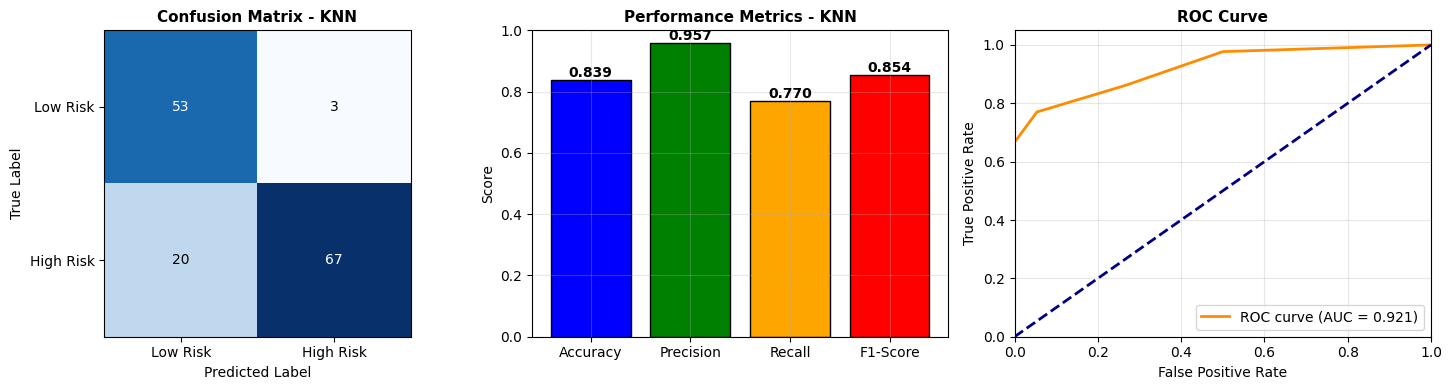

✓ KNN                            | Accuracy: 0.8392 | F1-Score: 0.8535 | Type: Base
  ROC-AUC: 0.9211

KNN Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.73      0.95      0.82        56
   High Risk       0.96      0.77      0.85        87

    accuracy                           0.84       143
   macro avg       0.84      0.86      0.84       143
weighted avg       0.87      0.84      0.84       143

------------------------------------------------------------

Evaluating Naive Bayes...


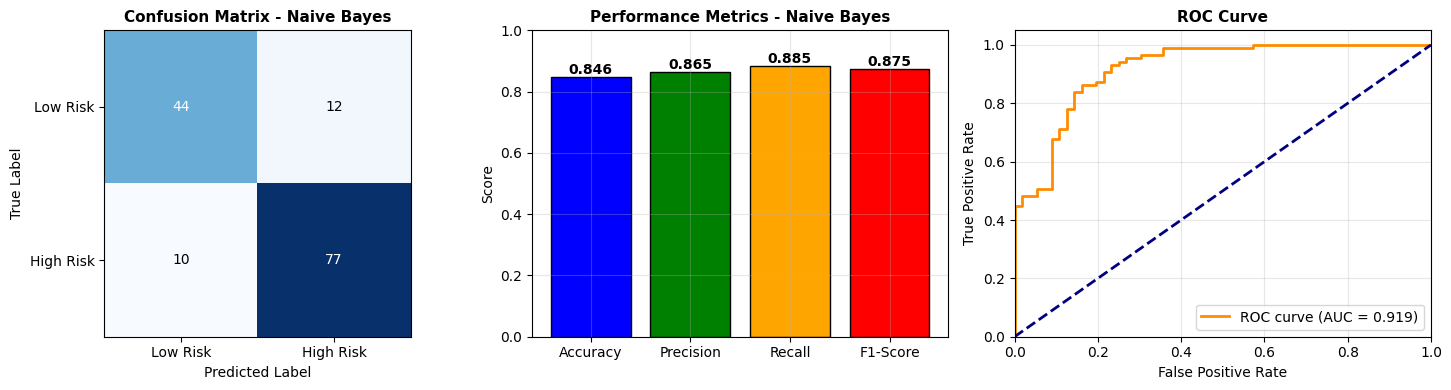

✓ Naive Bayes                    | Accuracy: 0.8462 | F1-Score: 0.8750 | Type: Base
  ROC-AUC: 0.9193

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.81      0.79      0.80        56
   High Risk       0.87      0.89      0.88        87

    accuracy                           0.85       143
   macro avg       0.84      0.84      0.84       143
weighted avg       0.85      0.85      0.85       143

------------------------------------------------------------

Evaluating ANN...


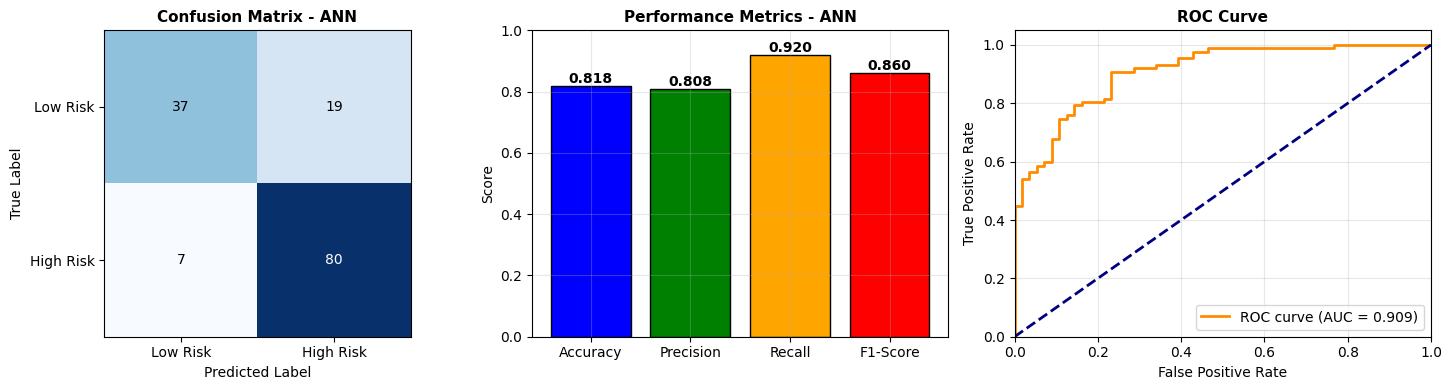

✓ ANN                            | Accuracy: 0.8182 | F1-Score: 0.8602 | Type: Neural Network
  ROC-AUC: 0.9087

ANN Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.84      0.66      0.74        56
   High Risk       0.81      0.92      0.86        87

    accuracy                           0.82       143
   macro avg       0.82      0.79      0.80       143
weighted avg       0.82      0.82      0.81       143

------------------------------------------------------------

Evaluating Random Forest...


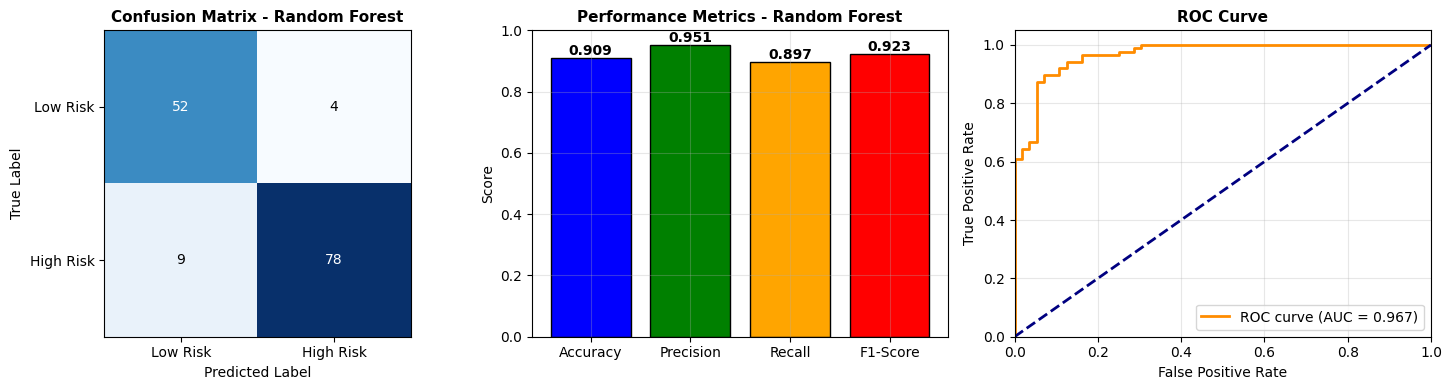

✓ Random Forest                  | Accuracy: 0.9091 | F1-Score: 0.9231 | Type: Ensemble
  ROC-AUC: 0.9672

Random Forest Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.85      0.93      0.89        56
   High Risk       0.95      0.90      0.92        87

    accuracy                           0.91       143
   macro avg       0.90      0.91      0.91       143
weighted avg       0.91      0.91      0.91       143

------------------------------------------------------------

Evaluating Bagging (DT)...


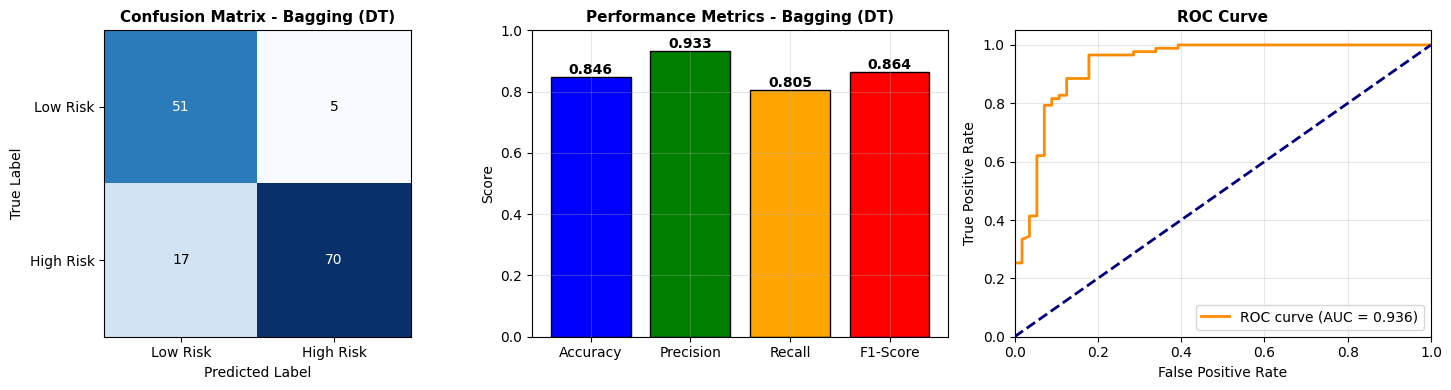

✓ Bagging (DT)                   | Accuracy: 0.8462 | F1-Score: 0.8642 | Type: Ensemble
  ROC-AUC: 0.9359

Bagging (DT) Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.75      0.91      0.82        56
   High Risk       0.93      0.80      0.86        87

    accuracy                           0.85       143
   macro avg       0.84      0.86      0.84       143
weighted avg       0.86      0.85      0.85       143

------------------------------------------------------------

Evaluating Gradient Boosting...


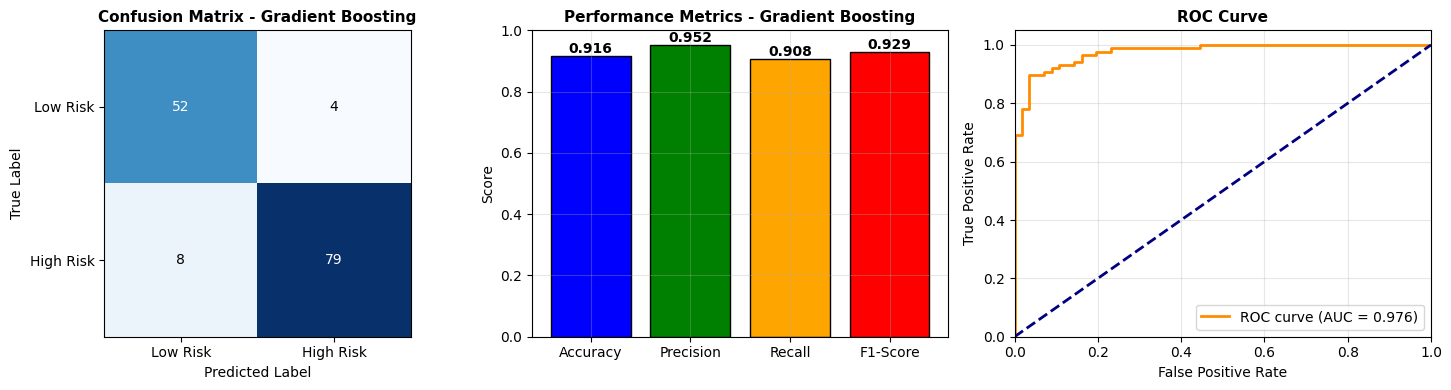

✓ Gradient Boosting              | Accuracy: 0.9161 | F1-Score: 0.9294 | Type: Ensemble
  ROC-AUC: 0.9758

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.87      0.93      0.90        56
   High Risk       0.95      0.91      0.93        87

    accuracy                           0.92       143
   macro avg       0.91      0.92      0.91       143
weighted avg       0.92      0.92      0.92       143

------------------------------------------------------------

Evaluating AdaBoost...


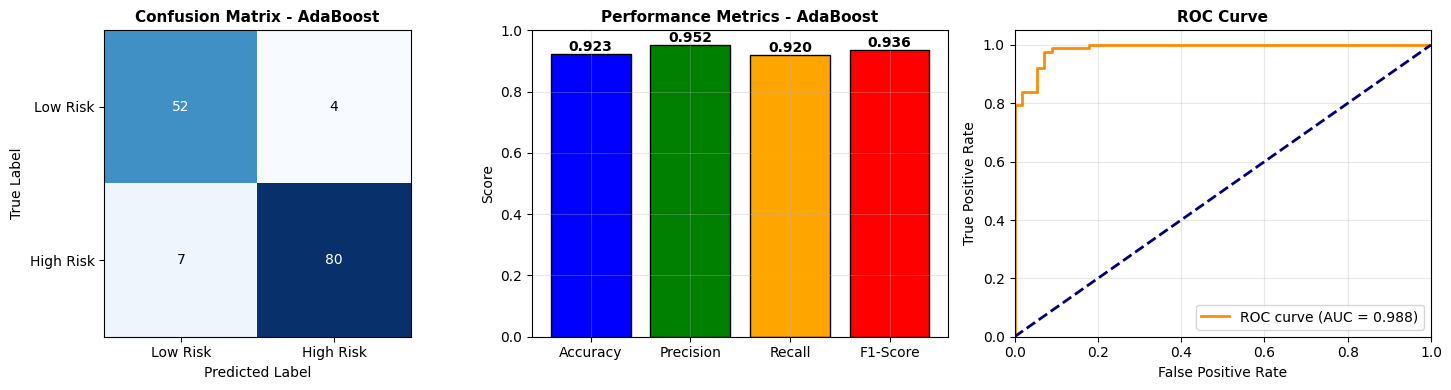

✓ AdaBoost                       | Accuracy: 0.9231 | F1-Score: 0.9357 | Type: Ensemble
  ROC-AUC: 0.9877

AdaBoost Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.88      0.93      0.90        56
   High Risk       0.95      0.92      0.94        87

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143

------------------------------------------------------------

Evaluating XGBoost...


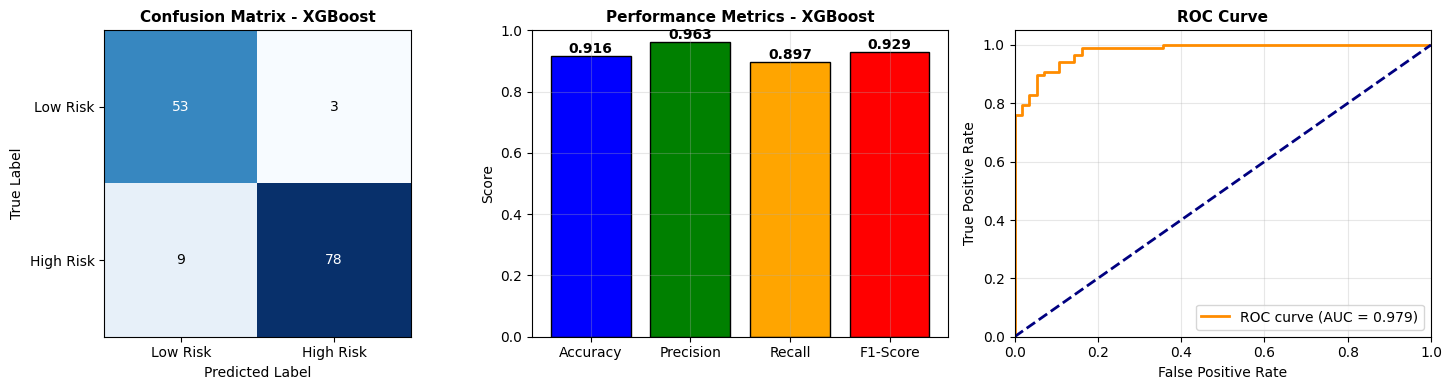

✓ XGBoost                        | Accuracy: 0.9161 | F1-Score: 0.9286 | Type: Ensemble
  ROC-AUC: 0.9789

XGBoost Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.85      0.95      0.90        56
   High Risk       0.96      0.90      0.93        87

    accuracy                           0.92       143
   macro avg       0.91      0.92      0.91       143
weighted avg       0.92      0.92      0.92       143

------------------------------------------------------------

MODEL PERFORMANCE COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC           Type
           AdaBoost  0.923077   0.952381 0.919540  0.935673 0.987685       Ensemble
  Gradient Boosting  0.916084   0.951807 0.908046  0.929412 0.975780       Ensemble
            XGBoost  0.916084   0.962963 0.896552  0.928571 0.978859       Ensemble
      Random Forest  0.909091   0.951220 0.896552  0.923077 0.967159       Ensemble
      Decision Tree  0.8

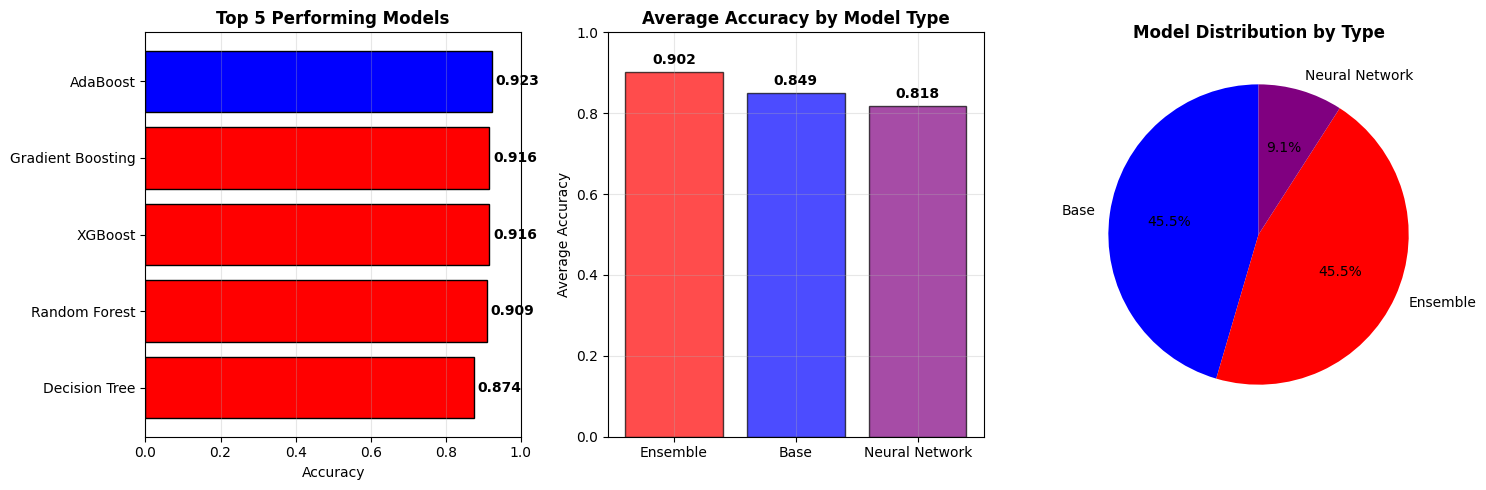


MODEL TYPE ANALYSIS

Base Models (5 models):
  Average Accuracy: 0.8490
  Average F1-Score: 0.8731
  Best Accuracy: 0.8741
  Worst Accuracy: 0.8322
    - Decision Tree                 : 0.8741
    - SVM                           : 0.8531
    - Naive Bayes                   : 0.8462
    - KNN                           : 0.8392
    - Logistic Regression           : 0.8322

Neural Network Models (1 models):
  Average Accuracy: 0.8182
  Average F1-Score: 0.8602
  Best Accuracy: 0.8182
  Worst Accuracy: 0.8182
    - ANN                           : 0.8182

Ensemble Models (5 models):
  Average Accuracy: 0.9021
  Average F1-Score: 0.9162
  Best Accuracy: 0.9231
  Worst Accuracy: 0.8462
    - AdaBoost                      : 0.9231
    - XGBoost                       : 0.9161
    - Gradient Boosting             : 0.9161
    - Random Forest                 : 0.9091
    - Bagging (DT)                  : 0.8462

----------------------------------------
PERFORMANCE COMPARISON
---------------------

In [10]:
# ============================================
# 6. MODEL EVALUATION
# ============================================
print("\n" + "="*60)
print("6. MODEL EVALUATION")
print("="*60)

def evaluate_model(model, X_test, y_test, model_name):
    try:
        y_pred = model.predict(X_test)

        # Handle models that don't have predict_proba
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            # For SVM without probability=True
            y_pred_proba = model.decision_function(X_test)
            # Scale to [0, 1] for ROC-AUC
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
        else:
            y_pred_proba = None

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        # Calculate ROC-AUC if possible
        if y_pred_proba is not None and len(np.unique(y_test)) > 1:
            try:
                roc_auc = roc_auc_score(y_test, y_pred_proba)
            except:
                roc_auc = None
        else:
            roc_auc = None

        # Determine model type
        ensemble_keywords = ['Random Forest', 'Bagging', 'Gradient Boosting',
                            'AdaBoost', 'XGBoost', 'Voting', 'Stacking', 'Ensemble']
        nn_keywords = ['ANN', 'Neural Network', 'MLP']

        if any(keyword in model_name for keyword in nn_keywords):
            model_type = 'Neural Network'
        elif any(keyword in model_name for keyword in ensemble_keywords):
            model_type = 'Ensemble'
        else:
            model_type = 'Base'

        metrics = {
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc,
            'Type': model_type
        }

        return metrics, y_pred, y_pred_proba

    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")
        return None, None, None


# Evaluate all models
results = []
predictions = {}
failed_models = []

for name, model in trained_models.items():
    print(f"\nEvaluating {name}...")
    try:
        metrics, y_pred, y_pred_proba = evaluate_model(model, X_test_scaled, y_test, name)

        if metrics is not None:
            results.append(metrics)
            predictions[name] = (y_pred, y_pred_proba)

            # Create evaluation visualization for each model
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))

            # Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            axes[0].set_title(f'Confusion Matrix - {name}', fontsize=11, fontweight='bold')
            axes[0].set_xticks([0, 1])
            axes[0].set_yticks([0, 1])
            axes[0].set_xticklabels(['Low Risk', 'High Risk'])
            axes[0].set_yticklabels(['Low Risk', 'High Risk'])
            axes[0].set_ylabel('True Label')
            axes[0].set_xlabel('Predicted Label')

            # Add text annotations
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    axes[0].text(j, i, format(cm[i, j], 'd'),
                                 ha="center", va="center",
                                 color="white" if cm[i, j] > thresh else "black")

            # Metrics bar chart
            metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
            metric_values = [
                metrics['Accuracy'],
                metrics['Precision'],
                metrics['Recall'],
                metrics['F1-Score']
            ]
            colors = ['blue', 'green', 'orange', 'red']

            bars = axes[1].bar(metric_names, metric_values, color=colors, edgecolor='black')
            axes[1].set_title(f'Performance Metrics - {name}', fontsize=11, fontweight='bold')
            axes[1].set_ylabel('Score')
            axes[1].set_ylim([0, 1])
            axes[1].grid(True, alpha=0.3)

            # Add value labels on bars
            for bar, value in zip(bars, metric_values):
                height = bar.get_height()
                axes[1].text(bar.get_x() + bar.get_width()/2., height,
                             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

            # ROC Curve (if available)
            if metrics['ROC-AUC'] is not None:
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                axes[2].plot(fpr, tpr, color='darkorange', lw=2,
                           label=f'ROC curve (AUC = {metrics["ROC-AUC"]:.3f})')
                axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                axes[2].set_xlim([0.0, 1.0])
                axes[2].set_ylim([0.0, 1.05])
                axes[2].set_xlabel('False Positive Rate')
                axes[2].set_ylabel('True Positive Rate')
                axes[2].set_title('ROC Curve', fontsize=11, fontweight='bold')
                axes[2].legend(loc="lower right")
                axes[2].grid(True, alpha=0.3)
            else:
                axes[2].text(0.5, 0.5, 'ROC-AUC\nNot Available',
                           ha='center', va='center', fontsize=12)
                axes[2].set_title('ROC Curve', fontsize=11, fontweight='bold')
                axes[2].axis('off')

            plt.tight_layout()
            plt.show()

            print(f"✓ {name:30} | Accuracy: {metrics['Accuracy']:.4f} | F1-Score: {metrics['F1-Score']:.4f} | Type: {metrics['Type']}")

            if metrics['ROC-AUC'] is not None:
                print(f"  ROC-AUC: {metrics['ROC-AUC']:.4f}")

            print(f"\n{name} Classification Report:")
            print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk'], zero_division=0))
            print("-" * 60)
        else:
            failed_models.append(name)

    except Exception as e:
        print(f"✗ Error evaluating {name}: {str(e)}")
        failed_models.append(name)


# Convert results to DataFrame
if results:
    results_df = pd.DataFrame(results)

    print("\n" + "="*60)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*60)

    # Sort by Accuracy, handle NaN values
    results_df_sorted = results_df.sort_values('Accuracy', ascending=False, na_position='last')
    print(results_df_sorted.to_string(index=False))

    if failed_models:
        print(f"\n⚠ Models that failed evaluation: {', '.join(failed_models)}")
else:
    print("✗ No models were successfully evaluated!")
    results_df = pd.DataFrame()


# ============================================
# 6.5 IDENTIFY BEST PERFORMING MODEL
# ============================================
if not results_df.empty:
    print("\n" + "="*60)
    print("BEST MODEL ANALYSIS")
    print("="*60)

    # Find best model by Accuracy
    best_model_row = results_df.loc[results_df['Accuracy'].idxmax()]
    best_model_name = best_model_row['Model']
    best_model = trained_models[best_model_name]

    print(f"\n🏆 BEST OVERALL MODEL: {best_model_name}")
    print(f"   Accuracy:  {best_model_row['Accuracy']:.4f}")
    print(f"   F1-Score:  {best_model_row['F1-Score']:.4f}")
    # Fix for ValueError: Invalid format specifier
    roc_auc_display = f"{best_model_row['ROC-AUC']:.4f}" if best_model_row['ROC-AUC'] is not None else 'N/A'
    print(f"   ROC-AUC:   {roc_auc_display}")
    print(f"   Type:      {best_model_row['Type']}")

    print("\n" + "-"*40)
    print("TOP 3 MODELS IN MY IMPLEMENTATION")
    print("-"*40)

    top_3 = results_df.nlargest(3, 'Accuracy')[['Model', 'Accuracy', 'Type']]
    for i, (_, row) in enumerate(top_3.iterrows(), 1):
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
        print(f"{medal} {row['Model']:30} {row['Accuracy']:.4f} ({row['Type']})")

    # Find best model by Type
    best_by_type = {}
    for model_type in results_df['Type'].unique():
        type_df = results_df[results_df['Type'] == model_type]
        if not type_df.empty:
            best_in_type = type_df.loc[type_df['Accuracy'].idxmax()]
            best_by_type[model_type] = best_in_type

    print("\n" + "-"*40)
    print("BEST MODEL BY TYPE")
    print("-"*40)
    for model_type, best_row in best_by_type.items():
        print(f"📊 {model_type:20}: {best_row['Model']:30} (Accuracy: {best_row['Accuracy']:.4f})")


    # Visualize comparisons
    plt.figure(figsize=(15, 5))

    # Subplot 1: Top 5 models
    plt.subplot(1, 3, 1)
    top_5 = results_df.nlargest(5, 'Accuracy')

    # Define colors by type
    type_colors = {'Base': 'blue', 'Ensemble': 'red', 'Neural Network': 'purple'}
    bar_colors = [type_colors.get(t, 'gray') for t in top_5['Type']]

    bars = plt.barh(top_5['Model'][::-1], top_5['Accuracy'][::-1],
                    color=bar_colors, edgecolor='black')
    plt.xlabel('Accuracy')
    plt.title('Top 5 Performing Models', fontweight='bold', fontsize=12)
    plt.xlim([0, 1])
    plt.grid(True, alpha=0.3, axis='x')

    for bar, acc in zip(bars, top_5['Accuracy'][::-1]):
        plt.text(acc + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{acc:.3f}', va='center', fontweight='bold')

    # Subplot 2: Performance by Type
    plt.subplot(1, 3, 2)
    type_avg = results_df.groupby('Type')['Accuracy'].mean().sort_values(ascending=False)

    colors = []
    for t in type_avg.index:
        if t == 'Neural Network':
            colors.append('purple')
        elif t == 'Ensemble':
            colors.append('red')
        else:
            colors.append('blue')

    bars = plt.bar(type_avg.index, type_avg.values, color=colors,
                   alpha=0.7, edgecolor='black')
    plt.ylabel('Average Accuracy')
    plt.title('Average Accuracy by Model Type', fontweight='bold', fontsize=12)
    plt.ylim([0, 1])
    plt.grid(True, alpha=0.3)

    for i, (type_name, avg) in enumerate(type_avg.items()):
        plt.text(i, avg + 0.02, f'{avg:.3f}', ha='center', fontweight='bold')

    # Subplot 3: Model Count by Type
    plt.subplot(1, 3, 3)
    type_counts = results_df['Type'].value_counts()

    colors = []
    for t in type_counts.index:
        if t == 'Neural Network':
            colors.append('purple')
        elif t == 'Ensemble':
            colors.append('red')
        else:
            colors.append('blue')

    plt.pie(type_counts.values, labels=type_counts.index, colors=colors,
            autopct='%1.1f%%', startangle=90)
    plt.title('Model Distribution by Type', fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Detailed analysis by model type
    print("\n" + "="*60)
    print("MODEL TYPE ANALYSIS")
    print("="*60)

    for model_type in results_df['Type'].unique():
        type_df = results_df[results_df['Type'] == model_type]
        if not type_df.empty:
            print(f"\n{model_type} Models ({len(type_df)} models):")
            print(f"  Average Accuracy: {type_df['Accuracy'].mean():.4f}")
            print(f"  Average F1-Score: {type_df['F1-Score'].mean():.4f}")
            print(f"  Best Accuracy: {type_df['Accuracy'].max():.4f}")
            print(f"  Worst Accuracy: {type_df['Accuracy'].min():.4f}")

            # Show models in this type sorted by accuracy
            sorted_type = type_df.sort_values('Accuracy', ascending=False)
            for _, row in sorted_type.iterrows():
                print(f"    - {row['Model']:30}: {row['Accuracy']:.4f}")

    # Compare Neural Network vs Ensemble vs Base
    if 'Neural Network' in results_df['Type'].values:
        nn_avg = results_df[results_df['Type'] == 'Neural Network']['Accuracy'].mean()
        ensemble_avg = results_df[results_df['Type'] == 'Ensemble']['Accuracy'].mean()
        base_avg = results_df[results_df['Type'] == 'Base']['Accuracy'].mean()

        print("\n" + "-"*40)
        print("PERFORMANCE COMPARISON")
        print("-"*40)
        print(f"Neural Network Average: {nn_avg:.4f}")
        print(f"Ensemble Average:       {ensemble_avg:.4f}")
        print(f"Base Average:           {base_avg:.4f}")

        if ensemble_avg > base_avg:
            improvement = ((ensemble_avg - base_avg) / base_avg) * 100
            print(f"✓ Ensemble methods are {improvement:.1f}% better than Base models")

        if nn_avg > base_avg:
            improvement = ((nn_avg - base_avg) / base_avg) * 100
            print(f"✓ Neural Networks are {improvement:.1f}% better than Base models")

    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"Total Models Tested: {len(results_df)}")
    print(f"Successfully Evaluated: {len(results_df)}")
    print(f"Failed Evaluations: {len(failed_models)}")

    if failed_models:
        print(f"Failed Models: {', '.join(failed_models)}")

    print(f"\n🏆 Best Overall Model: {best_model_name}")
    print(f"   Accuracy: {best_model_row['Accuracy']:.4f}")
    print(f"   Type: {best_model_row['Type']}")

    # Model type distribution
    type_dist = results_df['Type'].value_counts()
    print("\nModel Type Distribution:")
    for model_type, count in type_dist.items():
        print(f"  {model_type}: {count} models")

    print("="*60)


7. TRAINING LOSS CURVES
✓ Found loss curve for ANN
✓ Found training score for Gradient Boosting
✓ Found estimator errors for AdaBoost
✓ Found loss curve for XGBoost

Found 4 models with training history


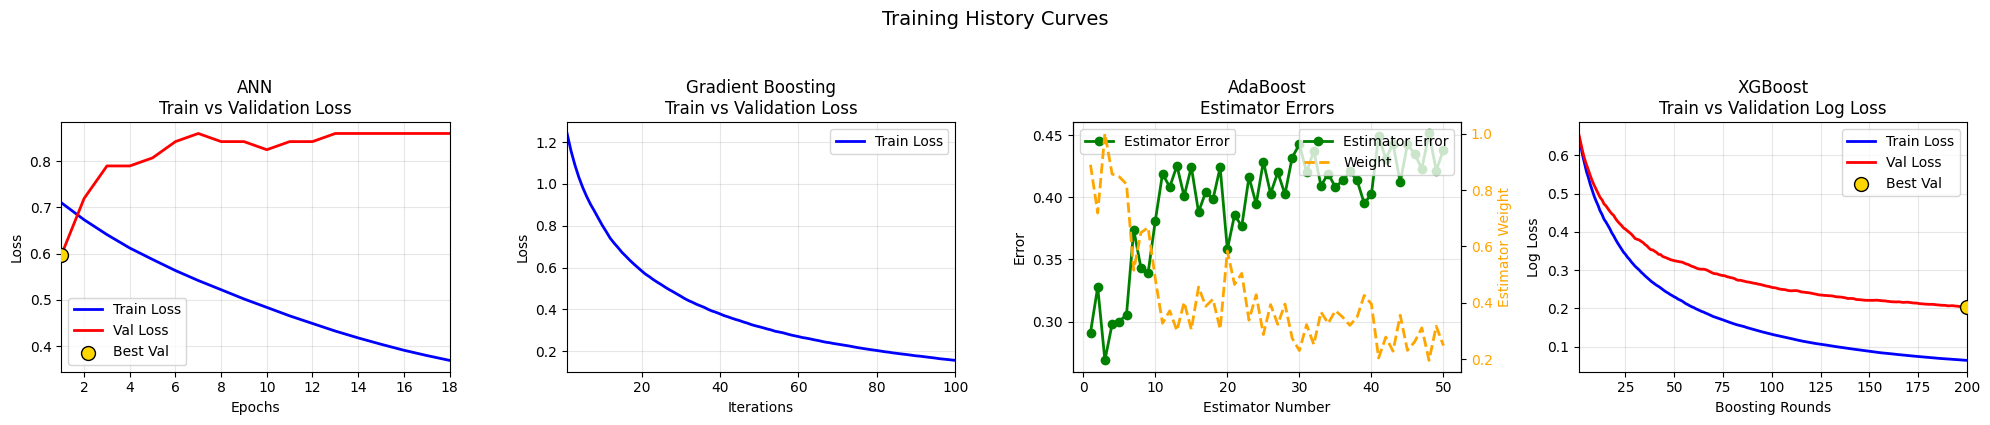


------------------------------------------------------------
TRAINING HISTORY SUMMARY
------------------------------------------------------------
ANN (ANN):
  Best iteration: 1
  Best val Log Loss: 0.5965
  Final val Log Loss: 0.8596
  Improvement: 0.0% reduction

Gradient Boosting (GradientBoosting):
  Training iterations: 100
  Final train loss: 0.1561

AdaBoost (AdaBoost):
  Number of estimators: 50
  Average error: 0.3973
  Minimum error: 0.2688
  Maximum error: 0.4513
  Average weight: 0.4210

XGBoost (XGBoost):
  Best iteration: 200
  Best val Log Loss: 0.2045
  Final val Log Loss: 0.2045
  Improvement: 68.9% reduction


LOSS CURVES COMPLETE


In [16]:
# ============================================
# 7. LOSS CURVES VISUALIZATION
# ============================================
print("\n" + "="*60)
print("7. TRAINING LOSS CURVES")
print("="*60)

# Collect loss curves from trained models
loss_curves_data = []

# Check each model for loss curves
for name, model in trained_models.items():
    # For ANN models
    if name.startswith('ANN') or 'Neural Network' in name:
        if hasattr(model, 'loss_curve_') and model.loss_curve_ is not None:
            loss_curves_data.append({
                'name': name,
                'type': 'ANN',
                'train_loss': model.loss_curve_,
                'val_loss': model.validation_scores_ if hasattr(model, 'validation_scores_') else None,
                'plot_type': 'loss_curve'
            })
            print(f"✓ Found loss curve for {name}")

    # For XGBoost models
    elif 'XGB' in name or 'XGBoost' in name:
        # Try to get eval results
        if hasattr(model, 'evals_result_'):
            xgb_evals_result = model.evals_result_
            if 'validation_0' in xgb_evals_result and 'validation_1' in xgb_evals_result:
                loss_curves_data.append({
                    'name': name,
                    'type': 'XGBoost',
                    'train_loss': xgb_evals_result['validation_0']['logloss'],
                    'val_loss': xgb_evals_result['validation_1']['logloss'],
                    'plot_type': 'loss_curve'
                })
                print(f"✓ Found loss curve for {name}")

    # For Gradient Boosting models
    elif 'Gradient' in name or 'GB' in name:
        if hasattr(model, 'train_score_') and model.train_score_ is not None:
            loss_curves_data.append({
                'name': name,
                'type': 'GradientBoosting',
                'train_loss': model.train_score_,
                'val_loss': None,
                'plot_type': 'loss_curve'
            })
            print(f"✓ Found training score for {name}")

    # For AdaBoost models - plot estimator errors or weights
    elif 'AdaBoost' in name:
        if hasattr(model, 'estimator_errors_') and model.estimator_errors_ is not None:
            loss_curves_data.append({
                'name': name,
                'type': 'AdaBoost',
                'estimator_errors': model.estimator_errors_,
                'estimator_weights': model.estimator_weights_ if hasattr(model, 'estimator_weights_') else None,
                'plot_type': 'adaboost'
            })
            print(f"✓ Found estimator errors for {name}")

if not loss_curves_data:
    print("\n⚠ No loss curves found in trained models")
else:
    print(f"\nFound {len(loss_curves_data)} models with training history")

    # Plot loss curves
    fig, axes = plt.subplots(1, len(loss_curves_data), figsize=(5*len(loss_curves_data), 4))

    if len(loss_curves_data) == 1:
        axes = [axes]

    for idx, data in enumerate(loss_curves_data):
        ax = axes[idx]

        if data['plot_type'] == 'loss_curve':
            # Plot training loss for ANN/XGB/GB
            train_loss = data['train_loss']
            epochs = range(1, len(train_loss) + 1)

            ax.plot(epochs, train_loss, 'b-', linewidth=2, label='Train Loss')

            # Plot validation loss if available
            if data['val_loss'] is not None:
                val_loss = data['val_loss']
                ax.plot(epochs, val_loss, 'r-', linewidth=2, label='Val Loss')

                # Mark best validation loss
                best_idx = np.argmin(val_loss)
                ax.scatter(best_idx + 1, val_loss[best_idx],
                          s=100, c='gold', edgecolor='black',
                          zorder=5, label=f'Best Val')

            # Customize based on model type
            if data['type'] == 'XGBoost':
                ax.set_xlabel('Boosting Rounds')
                ax.set_ylabel('Log Loss')
                metric_name = 'Log Loss'
            else:
                ax.set_xlabel('Epochs' if data['type'] == 'ANN' else 'Iterations')
                ax.set_ylabel('Loss')
                metric_name = 'Loss'

            ax.set_title(f"{data['name']}\nTrain vs Validation {metric_name}")
            ax.grid(True, alpha=0.3)
            ax.legend()
            ax.set_xlim([1, len(train_loss)])

        elif data['plot_type'] == 'adaboost':
            # Plot AdaBoost estimator errors
            estimator_errors = data['estimator_errors']
            estimators = range(1, len(estimator_errors) + 1)

            ax.plot(estimators, estimator_errors, 'g-', linewidth=2, marker='o', label='Estimator Error')
            ax.set_xlabel('Estimator Number')
            ax.set_ylabel('Error')
            ax.set_title(f"{data['name']}\nEstimator Errors")
            ax.grid(True, alpha=0.3)
            ax.legend()

            # Plot estimator weights if available (secondary axis)
            if data['estimator_weights'] is not None:
                ax2 = ax.twinx()
                weights = data['estimator_weights']
                ax2.plot(estimators, weights, 'orange', linewidth=2, linestyle='--', label='Weight')
                ax2.set_ylabel('Estimator Weight', color='orange')
                ax2.tick_params(axis='y', labelcolor='orange')

                # Combine legends
                lines1, labels1 = ax.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.suptitle("Training History Curves", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "-"*60)
    print("TRAINING HISTORY SUMMARY")
    print("-"*60)

    for data in loss_curves_data:
        if data['plot_type'] == 'loss_curve':
            if data['val_loss'] is not None:
                val_loss = data['val_loss']
                best_idx = np.argmin(val_loss)
                best_val = val_loss[best_idx]
                final_val = val_loss[-1]

                print(f"{data['name']} ({data['type']}):")
                print(f"  Best iteration: {best_idx + 1}")
                print(f"  Best val {metric_name}: {best_val:.4f}")
                print(f"  Final val {metric_name}: {final_val:.4f}")
                if len(val_loss) > 0:
                    improvement = ((val_loss[0] - best_val) / val_loss[0] * 100)
                    print(f"  Improvement: {improvement:.1f}% reduction")
            else:
                print(f"{data['name']} ({data['type']}):")
                print(f"  Training iterations: {len(data['train_loss'])}")
                print(f"  Final train loss: {data['train_loss'][-1]:.4f}")

        elif data['plot_type'] == 'adaboost':
            estimator_errors = data['estimator_errors']
            print(f"{data['name']} (AdaBoost):")
            print(f"  Number of estimators: {len(estimator_errors)}")
            print(f"  Average error: {np.mean(estimator_errors):.4f}")
            print(f"  Minimum error: {np.min(estimator_errors):.4f}")
            print(f"  Maximum error: {np.max(estimator_errors):.4f}")
            if data['estimator_weights'] is not None:
                weights = data['estimator_weights']
                print(f"  Average weight: {np.mean(weights):.4f}")
        print()

print("\n" + "="*60)
print("LOSS CURVES COMPLETE")
print("="*60)


8. BEST MODEL ANALYSIS

Best Model: AdaBoost
Accuracy: 0.9231
F1-Score: 0.9357

Cross-Validation Results for AdaBoost:
Scores: [0.92982456 0.92105263 0.92982456 0.93859649 0.93859649]
Mean CV Accuracy: 0.9316 (+/- 0.0131)

----------------------------------------
FEATURE IMPORTANCE (Best Model)
----------------------------------------
                Feature  Importance
7                   bmi    0.381767
1     physical_activity    0.150534
3  medication_adherence    0.149722
2                  diet    0.121854
4          stress_level    0.073496
0         blood_glucose    0.057471
5           sleep_hours    0.049802
6       hydration_level    0.015354


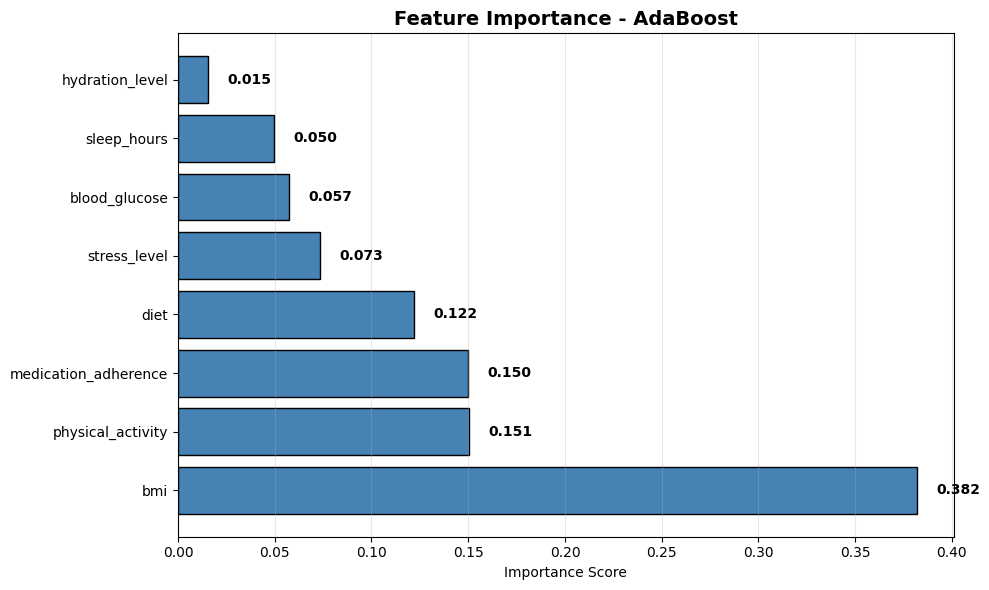


✓ Best model and scaler saved to disk


In [15]:
# ============================================
# 8. BEST MODEL ANALYSIS AND DEPLOYMENT
# ============================================
print("\n" + "="*60)
print("8. BEST MODEL ANALYSIS")
print("="*60)

# Identify best model
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_model = trained_models[best_model_name]
print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {results_df.loc[results_df['Accuracy'].idxmax(), 'Accuracy']:.4f}")
print(f"F1-Score: {results_df.loc[results_df['Accuracy'].idxmax(), 'F1-Score']:.4f}")

# Cross-validation for best model
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Results for {best_model_name}:")
print(f"Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Feature importance for best model
if hasattr(best_model, 'feature_importances_'):
    print("\n" + "-"*40)
    print("FEATURE IMPORTANCE (Best Model)")
    print("-"*40)
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print(feature_importance_df)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    bars = plt.barh(range(len(feature_importance_df)),
                    feature_importance_df['Importance'],
                    color='steelblue', edgecolor='black')
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
    plt.xlabel('Importance Score')
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, (bar, imp) in enumerate(zip(bars, feature_importance_df['Importance'])):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{imp:.3f}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Save the best model
import joblib
joblib.dump(best_model, 'best_diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\n✓ Best model and scaler saved to disk")




9. PREDICTION FUNCTION

Example Prediction (using optimized features):

Prediction Result:
Risk Prediction: High Risk
Confidence: 0.5751348738489354
Low Risk Probability: 0.42486512615106453
High Risk Probability: 0.5751348738489354

----------------------------------------
FEATURE CONTRIBUTIONS TO PREDICTION
----------------------------------------


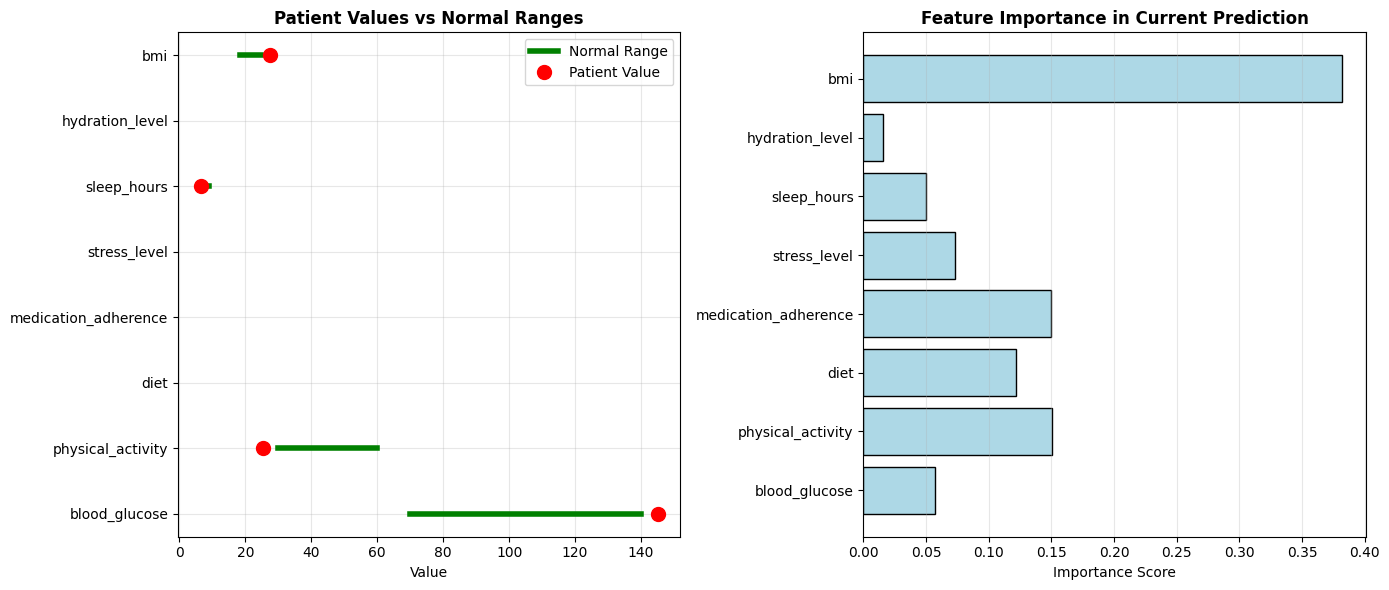


ML PIPELINE COMPLETED SUCCESSFULLY!

Key Improvements:
1. Removed weight and height (redundant with BMI)
2. Reduced multicollinearity
3. Used 8 optimized features instead of 10
4. Best Model: AdaBoost
5. Test Accuracy: 0.9231

Models available for use:
  - Logistic Regression
  - Decision Tree
  - SVM
  - KNN
  - Naive Bayes
  - Random Forest
  - Bagging (DT)
  - Gradient Boosting
  - AdaBoost


In [30]:
# ============================================
# 9. PREDICTION FUNCTION WITH NEW FEATURES
# ============================================
print("\n" + "="*60)
print("9. PREDICTION FUNCTION")
print("="*60)

def predict_diabetes_risk(bmi, blood_glucose, physical_activity,
                         diet, medication_adherence, stress_level,
                         sleep_hours, hydration_level):
    """
    Predict diabetes risk using optimized feature set
    Note: weight and height removed to avoid multicollinearity with BMI
    """
    # Prepare input array in the correct order
    input_data = np.array([[
        blood_glucose, physical_activity, diet,
        medication_adherence, stress_level, sleep_hours,
        hydration_level, bmi
    ]])

    # Scale input
    input_scaled = scaler.transform(input_data)

    # Get prediction
    prediction = best_model.predict(input_scaled)[0]
    probability = best_model.predict_proba(input_scaled)[0]

    risk_level = "Low Risk" if prediction == 0 else "High Risk"
    confidence = probability[prediction]

    # Get feature importance if available
    feature_contributions = {}
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        for i, feature in enumerate(feature_names):
            feature_contributions[feature] = {
                'value': input_data[0, i],
                'importance': importances[i]
            }

    return {
        'risk_prediction': risk_level,
        'confidence': float(confidence),
        'low_risk_probability': float(probability[0]),
        'high_risk_probability': float(probability[1]),
        'feature_contributions': feature_contributions if feature_contributions else None
    }

# Example usage
print("\nExample Prediction (using optimized features):")
example_result = predict_diabetes_risk(
    bmi=27.5,
    blood_glucose=145,
    physical_activity=25.5,
    diet=1,
    medication_adherence=1,
    stress_level=2,
    sleep_hours=6.5,
    hydration_level=1
)

print("\nPrediction Result:")
for key, value in example_result.items():
    if key != 'feature_contributions':
        print(f"{key.replace('_', ' ').title()}: {value}")

# Visualize prediction with feature contributions
if example_result['feature_contributions']:
    print("\n" + "-"*40)
    print("FEATURE CONTRIBUTIONS TO PREDICTION")
    print("-"*40)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Bar chart of feature values vs normal ranges
    axes[0].set_title('Patient Values vs Normal Ranges', fontsize=12, fontweight='bold')

    # Normal ranges for features (example values)
    normal_ranges = {
        'bmi': (18.5, 24.9),
        'blood_glucose': (70, 140),
        'physical_activity': (30, 60),
        'sleep_hours': (7, 9)
    }

    for i, (feature, data) in enumerate(example_result['feature_contributions'].items()):
        if feature in normal_ranges:
            low, high = normal_ranges[feature]
            axes[0].plot([low, high], [i, i], 'g-', linewidth=4, label='Normal Range' if i==0 else "")
            axes[0].plot(data['value'], i, 'ro', markersize=10, label='Patient Value' if i==0 else "")

    axes[0].set_yticks(range(len(example_result['feature_contributions'])))
    axes[0].set_yticklabels(list(example_result['feature_contributions'].keys()))
    axes[0].set_xlabel('Value')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Feature importance in prediction
    axes[1].set_title('Feature Importance in Current Prediction', fontsize=12, fontweight='bold')
    features = list(example_result['feature_contributions'].keys())
    importances = [data['importance'] for data in example_result['feature_contributions'].values()]

    bars = axes[1].barh(features, importances, color='lightblue', edgecolor='black')
    axes[1].set_xlabel('Importance Score')
    axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("ML PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"\nKey Improvements:")
print(f"1. Removed weight and height (redundant with BMI)")
print(f"2. Reduced multicollinearity")
print(f"3. Used 8 optimized features instead of 10")
print(f"4. Best Model: {best_model_name}")
print(f"5. Test Accuracy: {results_df.loc[results_df['Accuracy'].idxmax(), 'Accuracy']:.4f}")
print("\nModels available for use:")
for name in trained_models.keys():
    print(f"  - {name}")
print("="*60)